In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

# 1. 加载图像

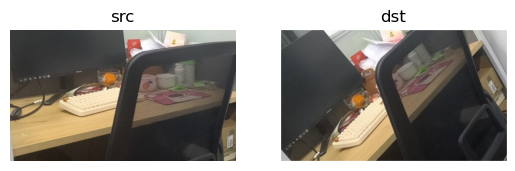

In [2]:
path1 = 'images/img2.jpg'
path2 = 'images/img1.jpg'
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('src'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('dst'), plt.axis('off')
plt.show()

# 2. SIFT特征点检测

In [3]:
# 检测sift特征点
sift = cv2.SIFT_create() # 使用cv2库中自带的sift特征检测器
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
print(des1.shape, des2.shape) # 128的特征向量

(286, 128) (437, 128)


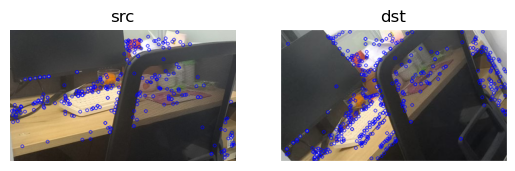

In [4]:
img_1 = cv2.drawKeypoints(img1, kp1, None, color= [255,0,0])
img_2 = cv2.drawKeypoints(img2, kp2, None, color= [255,0,0])
plt.subplot(121), plt.imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)), plt.title('src'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)), plt.title('dst'), plt.axis('off')
plt.show()

# 3. SIFT特征点匹配

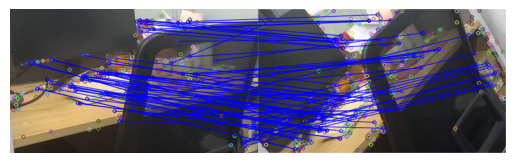

In [5]:
from scipy.spatial import KDTree
# 使用KDTree进行最近邻查询
tree = KDTree(des2)
dist, indices = tree.query(des1, k=2)
# 对特征点进行筛选，保留最近邻距离小于0.75倍次近邻距离的点
good_indices = np.where(dist[:, 0] < 0.75 * dist[:, 1])[0]
matches = []
for idx in good_indices:
    matches.append(cv2.DMatch(idx, indices[idx][0], dist[idx][0]))

# 绘制匹配结果
img_match = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, matchColor= [255,0,0])
plt.axis('off')
plt.imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))

# 4.计算单应性矩阵

In [6]:
# Computers a homography from 4-correspondences
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)
    matrixA = np.matrix(aList)
    #svd composition
    u, s, v = np.linalg.svd(matrixA)
    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))
    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [7]:
#Calculate the geometric distance between estimated points and original points
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0].item(0), correspondence[0].item(1), 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[0].item(2), correspondence[0].item(3), 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

In [8]:
#Runs through ransac algorithm, creating homographies from random correspondences
def ransac(corr, thresh):
    maxInliers = []
    finalH = None
    for i in range(1000):
        #find 4 random points to calculate a homography
        corr1 = corr[random.randrange(0, len(corr))]
        corr2 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((corr1, corr2))
        corr3 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr3))
        corr4 = corr[random.randrange(0, len(corr))]
        randomFour = np.vstack((randomFour, corr4))

        #call the homography function on those points
        h = calculateHomography(randomFour)
        inliers = []
        for i in range(len(corr)):
            d = geometricDistance(corr[i], h)
            if d < 5:
                inliers.append(corr[i])
        # update H
        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        # meet the condition
        if len(maxInliers) > (len(corr)*thresh):
            break
    return finalH, maxInliers

In [9]:
correspondenceList = []
estimation_thresh = 0.8
keypoints = [kp1, kp2]
for match in matches:
    (x1, y1) = keypoints[0][match.queryIdx].pt
    (x2, y2) = keypoints[1][match.trainIdx].pt
    correspondenceList.append([x1, y1, x2, y2])
corrs = np.matrix(correspondenceList)

#run ransac algorithm
finalH, inliers = ransac(corrs, estimation_thresh)
print("matches count: ", len(correspondenceList))
print("Final homography: \n", finalH)
print("Final inliers count: ", len(inliers))

matches count:  87
Final homography: 
 [[ 9.35804588e-01  7.94581731e-01 -9.41677255e+01]
 [-5.56626327e-01  9.36912197e-01  1.72421795e+02]
 [ 1.72726919e-04  4.72348510e-04  1.00000000e+00]]
Final inliers count:  70


In [10]:
height, width, channel = img2.shape
out = np.zeros((height, width, 3), dtype='uint8')

In [11]:
for i in range(height):
    for j in range(width):
        im_coord = np.array([[j], [i], [1]])
        trans_coord = np.matmul(finalH, im_coord)
        trans_x = int(trans_coord[0] / trans_coord[2])
        trans_y = int(trans_coord[1] / trans_coord[2])
        if trans_x>=0 and trans_x< width and trans_y >=0 and trans_y<height-1:
            out[i][j] = img2[trans_y][trans_x]

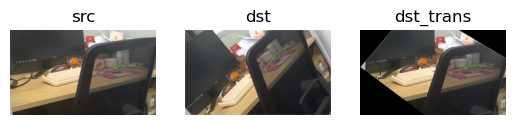

In [12]:
plt.subplot(131), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)), plt.title('src'), plt.axis('off')
plt.subplot(132), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)), plt.title('dst'), plt.axis('off')
plt.subplot(133), plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)), plt.title('dst_trans'), plt.axis('off')
plt.show()